In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import compute_pers, calc_bottleneck, downsample_average, SEDT
from generate_examples import create_diskwithmanyspots
import matplotlib.pyplot as plt

([], [])

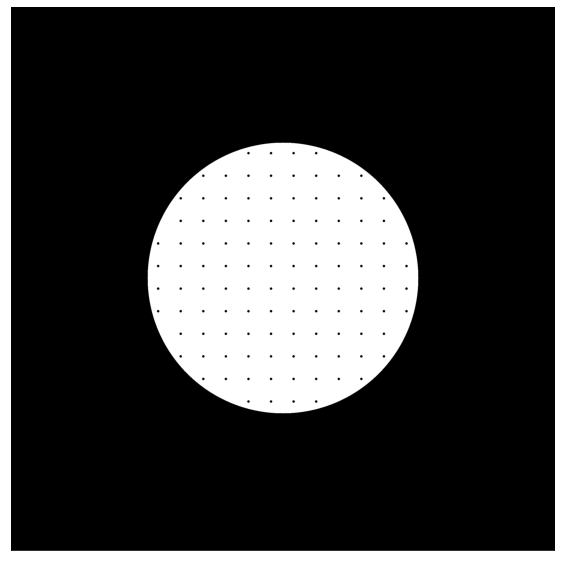

In [2]:
data = create_diskwithmanyspots()
plt.figure(figsize=(10,10))
plt.imshow(data, cmap='binary_r')

plt.xticks([])
plt.yticks([])

In [3]:
HR_binary = np.copy(data)
HR_size = len(HR_binary)
HR_SEDT = SEDT(HR_binary)

print(HR_size)

ks_list = [128, 64, 32, 16, 8, 4, 2]
ks_list.reverse()

2048


### Compute bound from Thm IV.2

In [4]:
leash_approx = []
for ks in ks_list:
    binary = downsample_average(HR_binary, ks, t=0.5)
    smallsedt = SEDT(binary) * HR_size/len(binary)

    rho = downsample_average(HR_binary, ks, t=None, nothreshold=True)

    gr0 = (rho>=0.0001)*1
    gr1 = (rho>=0.9999)*1
    gr05 = (rho>0.5)*1

    comp1 = gr05 - gr1
    comp0 = gr0 - gr05
    
    try:
        comp1max = max(np.abs(smallsedt[comp1==1]))
    except:
        comp1max = 0
        
    try:
        comp0max = max(np.abs(smallsedt[comp0==1]))
    except:
        comp0max = 0
    
    leash_approx.append(max([comp1max,comp0max]))

In [5]:
kernel_size_list = [int(HR_size/i) for i in range(4,HR_size//2+1) if HR_size/i == int(HR_size/i)]

# Compute SEDT images
binary_image_list = [] # list of binary images
sedt_image_list = [] # list of sedt images
num_pixels_list = [] # list keeping track of resolution
for ks in kernel_size_list:
    # Downsample with threshold t=0.5
    img = downsample_average(HR_binary, ks, t=0.5)
    
    # Keep list of binary images
    binary_image_list.append(np.copy(img))
        
    sedt = SEDT(img)
    
    num_pixels_list.append(len(sedt))
    
    # Scale SEDT
    scale = HR_size/len(sedt)
    sedt_image_list.append( sedt*scale )
        
# lastly add in high resolution version
binary_image_list.append(np.copy(HR_binary))
sedt_image_list.append(SEDT(HR_binary))
num_pixels_list.append(HR_size)

### Compute Persistence Diagrams

In [6]:
All_Dgms = []
maxes = []
mins = []
for i,image in enumerate(sedt_image_list):
    
    # Keep track of max and mins of images
    maxes.append(np.amax(image))
    mins.append(np.amin(image))
    
    # Compute pers dgms
    dgms = compute_pers(image, dgm_format='giotto') # Diagrams from T Construction
    
    # Keep list of all diagrams
    All_Dgms.append(dgms)

### Compute bottleneck distances

In [7]:
bdists_0_HR = []
dim = 0
for i in range(len(All_Dgms)):
    dgm_a = All_Dgms[i][0]
    dgm_a = dgm_a[dgm_a[:,2] == dim]
    
    dgm_b = All_Dgms[-1][0]
    dgm_b = dgm_b[dgm_b[:,2] == dim]

    d = calc_bottleneck(dgm_a, dgm_b)
    bdists_0_HR.append( d )
    
bdists_1_HR = [] 
dim = 1
for i in range(len(All_Dgms)):
    dgm_a = All_Dgms[i][0]
    dgm_a = dgm_a[dgm_a[:,2] == dim]
    
    dgm_b = All_Dgms[-1][0]
    dgm_b = dgm_b[dgm_b[:,2] == dim]

    d = calc_bottleneck(dgm_a, dgm_b)
    bdists_1_HR.append( d )

### Calculate bound based on Thm IV.1 & Remark IV.9


In [8]:
bound = []

mmin = min(2048/np.array(num_pixels_list))
mmax = max(2048/np.array(num_pixels_list))

x_resolution = []
x_pixelsize = []

w = 85
R2 = 510
R1 = 5
for p in np.linspace(min(np.array(num_pixels_list)),max(np.array(num_pixels_list)),50):
    r = 2048/p
    if r < (1/np.sqrt(2))*R1:
        bound.append( 2*np.sqrt(2)*r ) 
        
        x_resolution.append(2048/r)
        x_pixelsize.append(r)
        
    elif r >= (1/np.sqrt(2))*R1 and r<= w/2 - R1/np.sqrt(2):
        bound.append( R2-w/np.sqrt(2)+R1+3*np.sqrt(2)*r ) 
    
        x_resolution.append(2048/r)
        x_pixelsize.append(r)

### Plot bottleneck distance vs resolution and bottleneck distance vs pixel size

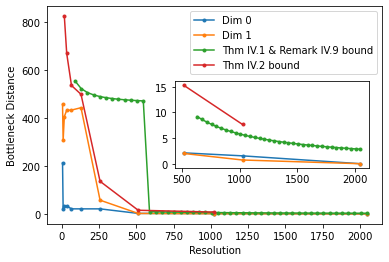

In [9]:
fig, ax1 = plt.subplots(figsize=(6,4))
plt.plot(np.array(num_pixels_list), bdists_0_HR, label='Dim 0',marker='.')
plt.plot(np.array(num_pixels_list),bdists_1_HR, label='Dim 1',marker='.')
plt.plot(x_resolution, bound, label='Thm IV.1 & Remark IV.9 bound', c='C2',marker='.') #, s=20)
plt.plot(2048/np.array(ks_list), np.array(leash_approx)+2*np.sqrt(2)*np.array(ks_list), label='Thm IV.2 bound', c='C3',marker='.')

plt.xlabel('Resolution')
plt.ylabel('Bottleneck Distance')
plt.legend()

# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.42, 0.32, 0.45, 0.3]
ax2 = fig.add_axes([left, bottom, width, height])
j = 13
ax2.plot(x_resolution[j:], bound[j:], label='Bound', c='C2', marker='.')
ax2.plot(np.array(num_pixels_list)[-3:], bdists_0_HR[-3:], label='Dim 0',marker='.')
ax2.plot(np.array(num_pixels_list)[-3:],bdists_1_HR[-3:], label='Dim 1',marker='.')
plt.plot(2048/np.array(ks_list)[:2], (np.array(leash_approx)+2*np.sqrt(2)*np.array(ks_list))[:2], label='Thm IV.2', c='C3',marker='.')

plt.savefig('Figs/DiskWithManySpots_Resolution_wbounds.png', dpi=300, bbox_inches='tight')

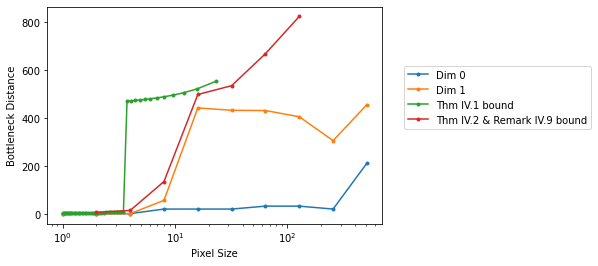

In [10]:
fig, ax1 = plt.subplots(figsize=(6,4))
plt.semilogx(2048/np.array(num_pixels_list), bdists_0_HR, label='Dim 0',marker='.')
plt.plot(2048/np.array(num_pixels_list),bdists_1_HR, label='Dim 1',marker='.')
plt.plot(x_pixelsize, bound, label='Thm IV.1 bound', c='C2',marker='.')
plt.plot(np.array(ks_list), np.array(leash_approx)+2*np.sqrt(2)*np.array(ks_list), label='Thm IV.2 & Remark IV.9 bound', c='C3',marker='.')


plt.xlabel('Pixel Size')
plt.ylabel('Bottleneck Distance')
plt.legend(bbox_to_anchor=(1.05, 0.75))

plt.savefig('Figs/DiskWithManySpots_PixelSize_Log_wbounds.png', dpi=300, bbox_inches='tight')